# Making a package for systematics analysis

The idea of this notebook is to take a fully-converged MCMC fit and produce a package of data files suitable for analyzing the unmodelled systematics remaining in the data. It should contain:

* The best-fit parameter names, values, and uncertainties (covariance matrix)
* Names, values, and uncertainties on any parameters obtained by linear fitting
* Names, values, and uncertainties for derived parameters
* The astrometric parameters that went into the calculation
* The settings used in the fitting
* Residuals of the fitting, in the form of a matrix with columns time, residual (phase), uncertainty
* Derivatives of the residuals with respect to all fitted parameters
* Derivatives of an imaginary uniformly sampled data set with respect to all fitted parameters


In [4]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from glob import glob
import os
import time
import cPickle as pickle
import joblib

import scipy.linalg
import scipy.stats

import emcee
import numdifftools

import kepler
import threebody

In [6]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.viridis()

In [10]:
gr_params = dict(files="tuned_mueller_pulses_selected",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=(('AO1440',1.0),
                           ('GBT1500',1.0),
                           ('WSRT1400',1.0)),
                     kopeikin=False,
                     ppn_mode='GR',
                     linear_jumps=True,
                     linear_dm=True,
                     toa_mode="pipeline")
F_gr = threebody.Fitter(**gr_params)
params = gr_params.copy()
params["ppn_mode"] = "heavysimple"
F = threebody.Fitter(**params)
F.best_parameters = F_gr.best_parameters
F.best_parameters["ppn_mode"] = "heavysimple"
F.best_parameters["delta"] = 0
F.best_parameters["dbeta"] = 0
F.best_parameters["dgamma"] = 0
fitter_params = params

In [11]:
F.best_parameters

{'acosi_i': 1.4922596784609649978,
 'acosi_o': 91.530732348852743868,
 'asini_i': 1.2175268328187250986,
 'asini_o': 74.672695837636610457,
 'd_DECJ': 1.6847336940935975218e-07,
 'd_PMDEC': -1.9580532733266362e-10,
 'd_PMRA': 9.885280864586482e-11,
 'd_PX': -0.92477760701603597092,
 'd_RAJ': -3.2388334094615887816e-08,
 'dbeta': 0,
 'delta': 0,
 'delta_lan': -3.0460572022280719438e-05,
 'dgamma': 0,
 'eps1_i': 0.00068692611243786728556,
 'eps1_o': 0.035186244412656308993,
 'eps2_i': -9.1322420630293142815e-05,
 'eps2_o': -0.003462206702875036605,
 'f0': 365.95336876828094,
 'general': True,
 'j_AO1350': 5.4169010371405938449e-05,
 'j_AO1440': 4.8930549945746121983e-05,
 'j_AO327': 6.5301884179095320452e-05,
 'j_GBT1500': 6.2334158805205982467e-05,
 'j_GBT350': 1.8510494219682503864e-05,
 'j_GBT820': 6.7999885696179984064e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6586764591042250491e-05,
 'lan': 22.854202311569486596,
 'matrix_mode': 0,
 'pb_i': 1.6293969558060391417,
 'pb_o': 327.2

In [12]:
orbit = F.compute_orbit(F.best_parameters)
orbit

{'initial_values': array([ -9.01845800e+01,   7.21804078e+01,   1.76180992e+01,
         -5.68612000e+00,   4.03854967e+00,   1.38279207e+00,
          1.44464593e+00,  -9.95836396e+01,   6.41355501e+01,
          2.77122062e+01,   3.42898370e+01,  -4.26800759e+01,
          1.38094316e+00,   1.98304892e-01,   3.64461237e+02,
         -2.84202060e+02,  -7.51777459e+01,   3.43633325e+00,
          6.38735380e+00,  -5.51793707e+00,   4.11656150e-01,
          0.00000000e+00]),
 'n_evaluations': 1616975,
 'parameter_dict': {'acosi_i': 1.4922596784609649978,
  'acosi_o': 91.530732348852743868,
  'asini_i': 1.2175268328187250986,
  'asini_o': 74.672695837636610457,
  'd_DECJ': 1.6847336940935975218e-07,
  'd_PMDEC': -1.9580532733266362e-10,
  'd_PMRA': 9.885280864586482e-11,
  'd_PX': -0.92477760701603597092,
  'd_RAJ': -3.2388334094615887816e-08,
  'dbeta': 0,
  'delta': 0,
  'delta_lan': -3.0460572022280719438e-05,
  'dgamma': 0,
  'eps1_i': 0.00068692611243786728556,
  'eps1_o': 0.035186

157288.688201 24301


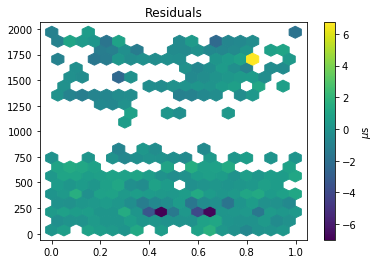

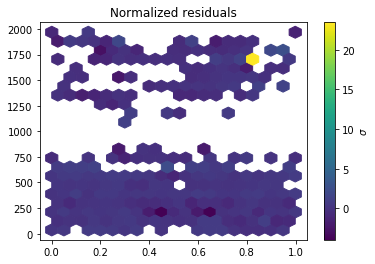

In [13]:
residuals = F.residuals()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.best_parameters['f0']*1e6, gridsize=20)
plt.title("Residuals")
plt.colorbar().set_label(r"$\mu$s")
plt.figure()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.phase_uncerts, gridsize=20)
plt.title("Normalized residuals")
plt.colorbar().set_label(r"$\sigma$")

print np.sum((residuals/F.phase_uncerts)**2), len(F.mjds)

In [14]:
M, linear_parameters = F.compute_linear_matrix()
linear_parameters

['d_DECJ',
 'd_DM',
 'd_PMDEC',
 'd_PMRA',
 'd_PX',
 'd_RAJ',
 'f0',
 'f1',
 'j_AO_430',
 'j_GBT_1400',
 'j_WSRT_1400',
 'j_WSRT_350',
 'phase']

In [15]:
M.shape

(24301, 13)

In [16]:
derivatives = {}

In [17]:
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

In [ ]:
def fres(p):
    print p
    bp  = F.best_parameters.copy()
    for (i,fp) in enumerate(F.parameters):
        bp[fp] += p[i]
    try:
        r = F.residuals(bp)
        return r
    except ValueError:
        return np.inf*np.ones_like(F.mjds)
x = np.zeros(len(F.parameters))
J = numdifftools.Jacobian(fres)(x)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.

In [55]:
for (i,p) in enumerate(F.parameters):
    derivatives[p] = J[:,i]

In [58]:
np.savez_compressed(
    "systematics-package.npz",
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    )

In [47]:
numdifftools.Derivative?

In [71]:
d = dict(
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    raw_uncerts=F.raw_uncerts,
    f0=F.best_parameters['f0'],
    efacs=fitter_params['efac'],
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    )
with open("systematics-package.pickle","wb") as f:
    pickle.dump(d,f)

In [63]:
dir(F)

[autoreload of numpy.compat failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name _inspect
]
[autoreload of numpy.core failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name multiarray
]
[autoreload of numpy failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name add_newdocs
]
[autoreload of numpy.fft failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportErro

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'args',
 'base_mjd',
 'best_errors',
 'best_parameters',
 'bootstrap',
 'chi2',
 'compute_linear_matrix',
 'compute_linear_parts',
 'compute_orbit',
 'derivs',
 'dof',
 'efac',
 'files',
 'fit',
 'fit_pm',
 'fit_pos',
 'fit_px',
 'general',
 'ix',
 'jmatrix',
 'jnames',
 'kopeikin',
 'last_orbit',
 'last_p',
 'linear_jumps',
 'lnprior',
 'lnprob',
 'make_mfun',
 'matrix_mode',
 'mjds',
 'parameters',
 'parfile',
 'phase_uncerts',
 'ppn_mode',
 'priors',
 'pulses',
 'raw_uncerts',
 'residuals',
 'shapiro',
 'special',
 't2_astrometry',
 'tel_base',
 'tel_list',
 'tels',
 'tol',
 'tzrmjd_base',
 'uncerts',
 'use_quad']

In [67]:
F.phase_uncerts/(F.best_parameters['f0']*F.raw_uncerts)

array([ 1.11,  1.11,  1.11, ...,  1.11,  1.11,  1.11])

In [70]:
fitter_params

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': 'auto'}

In [69]:
F.efac

1.0